In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.multicomp import MultiComparison
from sklearn.cluster import KMeans
import numpy as np
pd.set_option('display.width', 2000)

In [39]:
nucleus_df = pd.read_csv('csv/nuclei3.csv')

  Condition  CytoCh2Intensity
0    Contra          2.479076
1      Ipsi          3.404386
2      Sham          6.167259


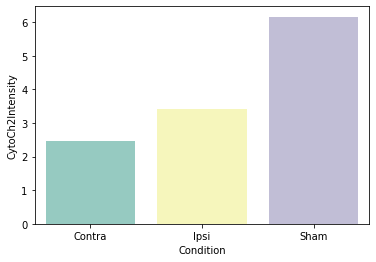

In [40]:

mean_intensity = nucleus_df.groupby('Condition')['CytoCh2Intensity'].mean().reset_index()

print(mean_intensity)

# Plotting
sns.barplot(data=mean_intensity, x='Condition', y='CytoCh2Intensity', palette='Set3')
plt.show()

In [44]:
import napari
all_sorted_clusters = []
for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    list = df['CytoCh2Intensity']
    intensity_values_reshaped = np.array(list).reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto")
    clusters = kmeans.fit_predict(intensity_values_reshaped)
    sorted_clusters = np.argsort(kmeans.cluster_centers_.flatten())
    all_sorted_clusters.append(sorted_clusters)



common_ordering = np.argsort(np.mean(all_sorted_clusters, axis=0))

# Assign consistent cluster labels based on the common ordering
consistent_labels = {common_ordering[0]: 0, common_ordering[1]: 1}

nucleus_df['Cluster_Label'] = np.nan
for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    intensity_values = df['CytoCh2Intensity'].values.reshape(-1, 1)
    kmeans = KMeans(n_clusters=2, random_state=42, n_init="auto", init=kmeans.cluster_centers_[common_ordering].reshape(-1, 1))
    clusters = kmeans.fit_predict(intensity_values)
    nucleus_df.loc[df.index, 'Cluster_Label'] = [consistent_labels[cluster] for cluster in clusters]

cd86_df = nucleus_df[nucleus_df['Cluster_Label'] == 1]
img1_df = cd86_df[cd86_df['ImageName'] == 'HI 2 Contralateral Mouse 9 Slide17 G4green NeuNpink CD86red 40x 4x4 technical replica2.lsm']

centroids = img1_df['Centroid'].apply(eval)

# Convert centroids to a NumPy array
centroids_array = np.array(centroids.tolist())  # Transpose the array to get the desired shape

# Check the shape of the centroids array

from skimage import io
#img= io.imread("D:/Users/Jonas/nuclei\imagesAndMasks\images_HI_contra\HI 2 Contralateral Mouse 9 Slide17 G4green NeuNpink CD86red 40x 4x4 technical replica2.lsm")

#viewer = napari.view_image(img, scale =([0.9278, 0.3459, 0.3459]), channel_axis=3 )
#viewer.add_points(centroids_array, size=10, symbol='cross', edge_color='blue', face_color='blue', name='Nuclei Centroids', scale=([0.9278, 0.3459, 0.3459]))
#napari.run()
grouped_df = nucleus_df.groupby(['ImageName', 'Condition', 'Cluster_Label']).size().unstack(fill_value=0)

# Reset index to make 'ImageName', 'Condition', and 'Cluster_Label' as columns
grouped_df.reset_index(inplace=True)
print(grouped_df)


Cluster_Label                                          ImageName Condition   0.0   1.0
0              HI 1 Contralateral Mouse 8 Slide18 G4green Neu...    Contra  6879   464
1              HI 1 Ipsilateral Mouse 8 Slide18 G4green NeuNp...      Ipsi  7753  1009
2              HI 1 Ipsilateral Mouse 8 Slide18 G4green NeuNp...      Ipsi  5726   627
3              HI 2 Contralateral Mouse 9 Slide17 G4green Neu...    Contra  6376   470
4              HI 2 Contralateral Mouse 9 Slide17 G4green Neu...    Contra  6803   464
5              HI 2 Ipsilateral Mouse 9 Slide17 G4green NeuNp...      Ipsi  5586  1456
6              HI 2 Ipsilateral Mouse 9 Slide17 G4green NeuNp...      Ipsi  5225  1434
7              HI 3 Contralateral Mouse 10 Slide18 G4green Ne...    Contra  6154   626
8              HI 3 Ipsilateral Mouse 10 Slide18 G4green NeuN...      Ipsi  5451   859
9              HI 3 Ipsilateral Mouse 10 Slide18 G4green NeuN...      Ipsi  5485   597
10             Sham 1 Contralateral Mouse 6

/Users/jonas/miniforge3/envs/naparienv2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/jonas/miniforge3/envs/naparienv2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


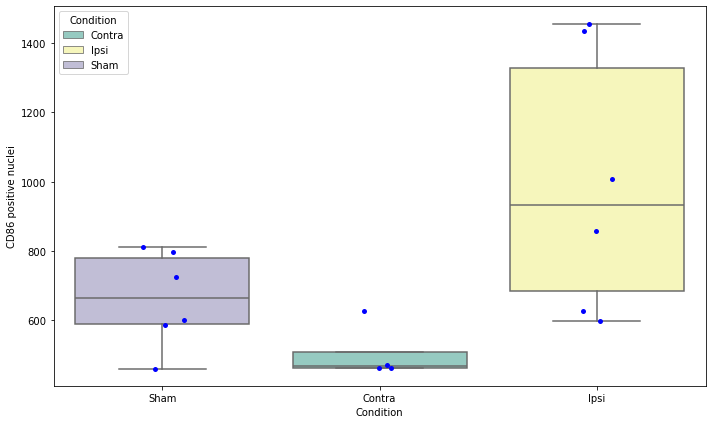

In [45]:

order = ['Sham', 'Contra', 'Ipsi']
plt.figure(figsize=(10, 6))  # Adjust size as needed
sns.boxplot(data=grouped_df, x='Condition', y=1, showfliers=False, order=order, hue='Condition', palette='Set3', dodge=False)
sns.stripplot(data=grouped_df, x='Condition', y=1, order=order, color='Blue', dodge=False)
plt.xlabel('Condition')
plt.ylabel('CD86 positive nuclei')
plt.legend(title='Condition')
plt.tight_layout()
#plt.savefig("plots/cd86Positive.pdf")
plt.show()

In [43]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

print(grouped_df.keys())

anova_results = f_oneway(grouped_df[grouped_df['Condition'] == 'Contra'][1.0],
                         grouped_df[grouped_df['Condition'] == 'Ipsi'][1.0],
                         grouped_df[grouped_df['Condition'] == 'Sham'][1.0])

# Perform Tukey HSD post hoc test
tukey_results = pairwise_tukeyhsd(grouped_df[1.0], grouped_df['Condition'])

print("ANOVA Results:")
print("F-statistic:", anova_results.statistic)
print("p-value:", anova_results.pvalue)

print("\nTukey HSD Results:")
print(tukey_results)



Index(['ImageName', 'Condition', 0.0, 1.0], dtype='object', name='Cluster_Label')
ANOVA Results:
F-statistic: 5.071629242207331
p-value: 0.023543579976500674

Tukey HSD Results:
 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
Contra   Ipsi    491.0 0.0255   60.018 921.982   True
Contra   Sham    158.0 0.6089 -272.982 588.982  False
  Ipsi   Sham   -333.0 0.0945 -718.482  52.482  False
-----------------------------------------------------


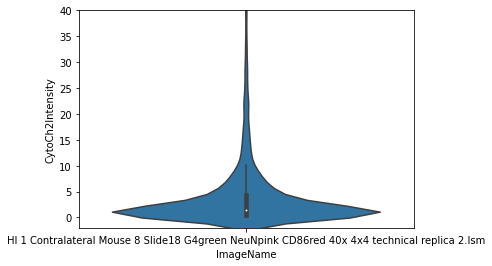

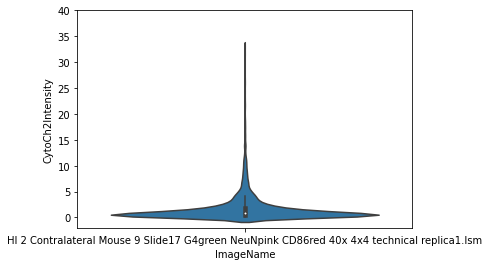

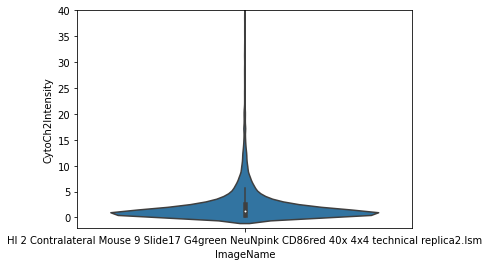

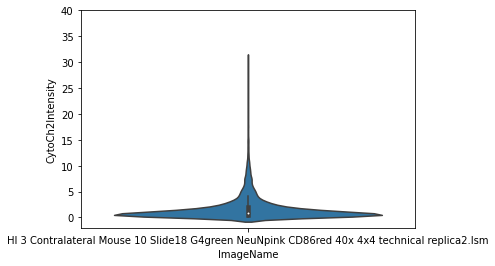

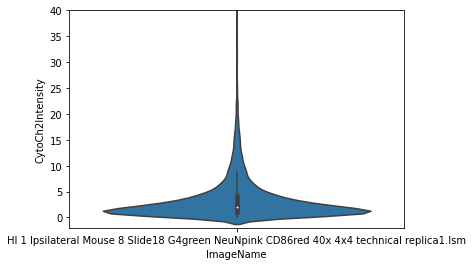

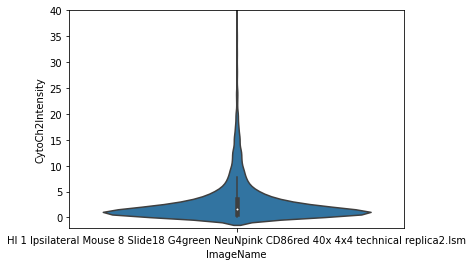

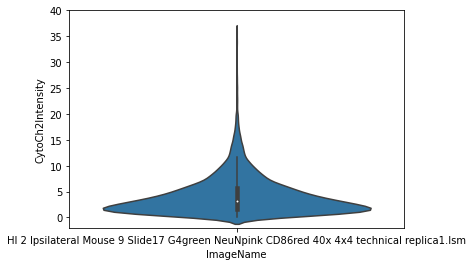

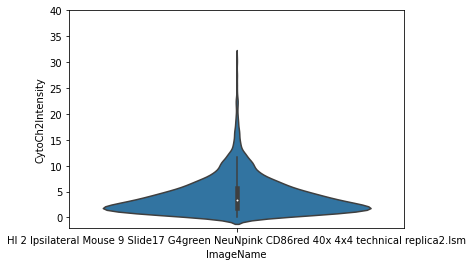

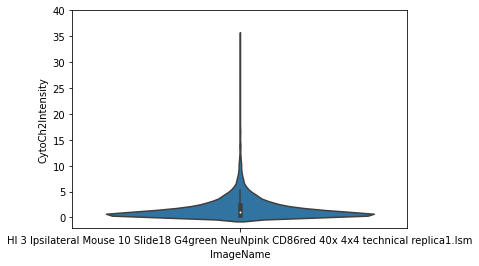

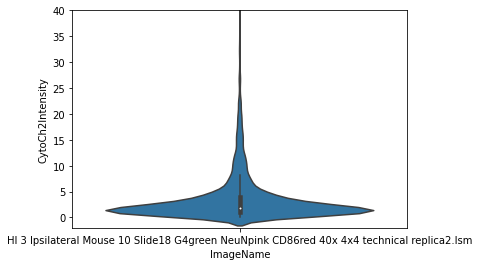

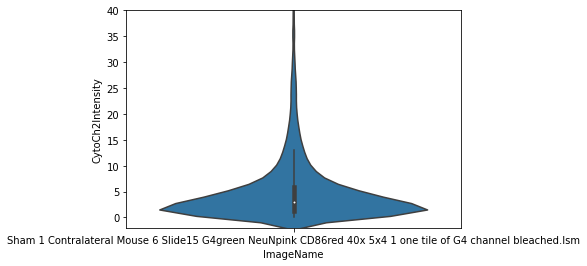

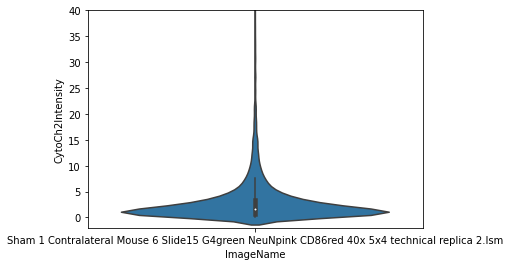

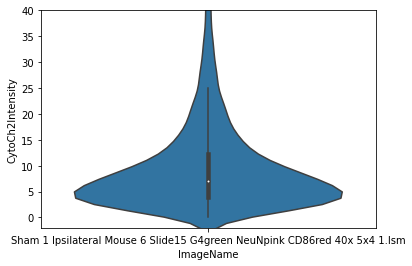

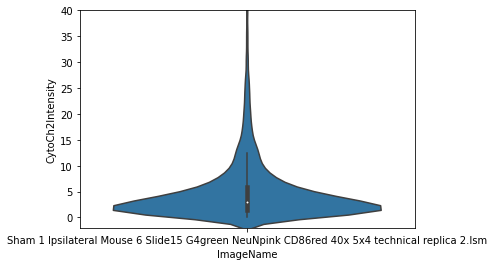

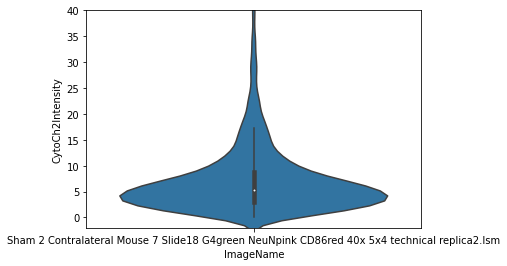

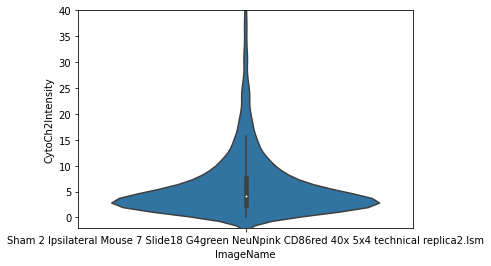

In [26]:
for name in nucleus_df['ImageName'].unique():
    df = nucleus_df[nucleus_df['ImageName'] == name]
    sns.violinplot(data=df, x='ImageName', y='CytoCh2Intensity')
    plt.ylim(-2,40)
    plt.show()